In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#pipeline imports
import env

from prepare import get_zillow_data, clean_data, get_hist, get_box, remove_outliers

#stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr
#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#math import
from math import sqrt

# Executive Summary
- Bathrooms, bedrooms and square footage where the primary features that drove tax values followed by location.
- With more time I would like to have explore more single units, age and property type.

## Planning
##### I want to find out if tax values differ for each of the following scenarios:
    - tax value to number of bathrooms
    - tax value to number of bedrooms
    - tax value to square footage
    - tax value to county

## Data Acquisition
- Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

In [2]:
df = get_zillow_data()
df.head(1)

,bathroomcnt,bedroomcnt,fips,yearbuilt,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,2.0,3.0,6037.0,1923.0,205123.0,2627.48,1316.0


In [ ]:
df.info()

##### Key Takeaways
- Columns need to be renamed
- Counts are off on a few columns, suggesting there may be nulls
- All columns are float dat types

In [ ]:
df.describe().T

##### Key Takeaways
- Average home is 3 bedroom, 2 baths, built in 1963, and with a square footage of 1934.
- Value of the average home is 535,000 dollars
- Home owners pay an average of 6,508 dollars
- Ignore fips count. It is counted as an float.

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

##### Key Takeaways
- As identified in the data summary there is several columns that have nulls to be filled.

## Prepare Data
- Based on the project details the following went into consideration:
    1. Calculated tax rate dividing taxamount by taxvaluedollarcnt
    2. Calculated age of home vice using year built by subtracting today's date by yearbuilt
    3. Filled all nulls with the respective mean values
    4. Dropped respective columns
    5. Converted all but tax_rate to integers. Left tax_rate as float.

In [3]:
df = clean_data(df)
df.head(1)

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate
0,2,3,6037,205123,1316,98,0.012809


In [ ]:
df.info()

#### Visualize prepared dataset

In [ ]:
get_hist(df)
get_box(df)

##### Takeaways
- Remove outliers for a more balanced view of the dataset for modeling.

In [6]:
df = remove_outliers(df, k = 1.5, col_list = ['bathrooms', 'bedrooms', 'tax_value', 'tax_rate', 'square_feet', 'age'])

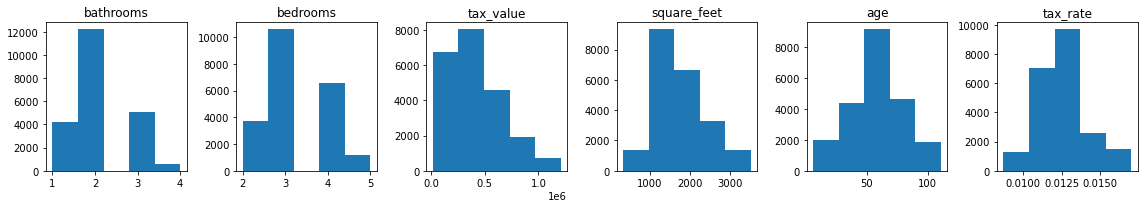

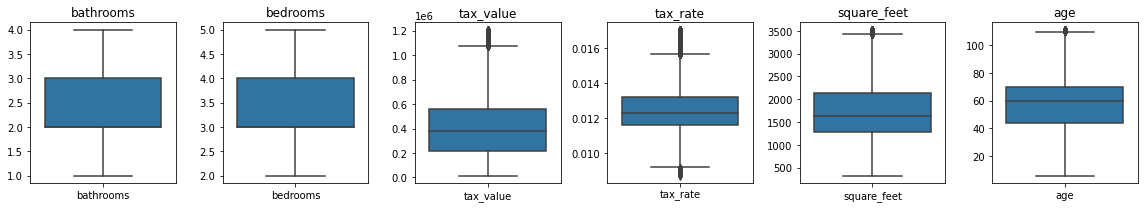

In [9]:
get_hist(df)
get_box(df)

##### Takeaways

1. Both tax_value and square_feet are right skewed
2. Normal distributions amongst the other features
3. Average home is between 2 and 3 bathrooms
4. 3 - 4 bedrooms
5. Average tax value is roughly 400K
6. Average tax rate just above 1.2 percent
7. Average square feet is just above 1500sqft
8. The average age of homes in this dataset is 60